# LangGraph Streaming Mode 

- Author: [Yejin Park](https://github.com/ppakyeah)
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

This tutorial demonstrates LangGraph's streaming capabilities by building an AI news search system.

It covers three key streaming modes: values, updates, and messages, each serving different output monitoring needs.

The tutorial also explores advanced features including subgraphs and tag-based filtering for enhanced control over real-time AI outputs.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Introduction to Streaming Modes](#introduction-to-streaming-modes)
- [Defining the Graph](#defining-the-graph)
- [Step-by-step output of a node](#step-by-step-output-of-a-node)
- [Advanced Streaming Features](#advanced-streaming-features)
- [Working with Subgraphs](#working-with-subgraphs)

### References

- [LangGraph: Streaming](https://langchain-ai.github.io/langgraph/how-tos/#streaming_1)
- [LangGraph: How to stream events](https://langchain-ai.github.io/langgraph/cloud/how-tos/stream_events/)
- [LangChain: astream_events()](https://python.langchain.com/api_reference/langchain/agents/langchain.agents.agent.AgentExecutor.html#langchain.agents.agent.AgentExecutor.astream_events)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_core",
        "langchain_openai",
        "langgraph"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "LangGraph Streaming Mode",
        }
    )

## Introduction to Streaming Modes
LangGraph supports multiple streaming modes. The main ones are:

- `values`: This streaming mode streams back values of the graph. This is the full state of the graph after each node is called.
- `updates`: This streaming mode streams back updates to the graph. This is the update to the state of the graph after each node is called.
- `messages`: This streaming mode streams LLM tokens from nodes as they are produced.

## Defining the Graph
We'll create a simple agent that can search news and process the results.

First, we'll define a class to fetch Google News search results:

In [4]:
import feedparser
from urllib.parse import quote
from typing import List, Dict, Optional


class GoogleNews:
    """
    A class for searching and retrieving Google News results.
    """

    def __init__(self):
        """
        Initialize the GoogleNews class.
        Sets up the base_url attribute.
        """
        self.base_url = "https://news.google.com/rss"

    def _fetch_news(self, url: str, k: int = 3) -> List[Dict[str, str]]:
        """
        Fetch news from the given URL.

        Args:
            url (str): URL to fetch news from
            k (int): Maximum number of news items to fetch (default: 3)

        Returns:
            List[Dict[str, str]]: List of dictionaries containing news titles and links
        """
        news_data = feedparser.parse(url)
        return [
            {"title": entry.title, "link": entry.link}
            for entry in news_data.entries[:k]
        ]

    def _collect_news(self, news_list: List[Dict[str, str]]) -> List[Dict[str, str]]:
        """
        Process and return a list of news items.

        Args:
            news_list (List[Dict[str, str]]): List of dictionaries containing news information

        Returns:
            List[Dict[str, str]]: List of dictionaries containing URLs and content
        """
        if not news_list:
            print("No news found for this keyword.")
            return []

        result = []
        for news in news_list:
            result.append({"url": news["link"], "content": news["title"]})

        return result

    def search_by_keyword(
        self, keyword: Optional[str] = None, k: int = 3
    ) -> List[Dict[str, str]]:
        """
        Search news by keyword.

        Args:
            keyword (Optional[str]): Keyword to search for (default: None)
            k (int): Maximum number of news items to search for (default: 3)

        Returns:
            List[Dict[str, str]]: List of dictionaries containing URLs and content
        """
        if keyword:
            encoded_keyword = quote(keyword)
            url = f"{self.base_url}/search?q={encoded_keyword}&hl=en&gl=US&ceid=US:en"
        else:
            url = f"{self.base_url}?hl=en&gl=US&ceid=US:en"
        news_list = self._fetch_news(url, k)
        return self._collect_news(news_list)

Now that we have our news fetching functionality, let's build the graph structure using LangGraph.

We'll create states, define tools, and establish the connections between different components:

In [5]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

########## 1. State Definition ##########
class State(TypedDict):
    messages: Annotated[list, add_messages]

########## 2. Tool Definition and Binding ##########
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )

tools = [search_keyword]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

########## 3. Add Nodes ##########
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[search_keyword])
graph_builder.add_node("tools", tool_node)

# Add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. Add Edges ##########
# tools > chatbot
graph_builder.add_edge("tools", "chatbot")
# START > chatbot
graph_builder.add_edge(START, "chatbot")
# chatbot > END
graph_builder.add_edge("chatbot", END)

# Compile graph
graph = graph_builder.compile()

Visualize the graph.

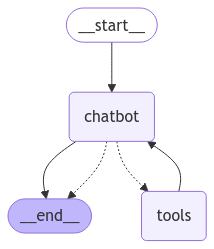

In [6]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

## Step-by-step output of a node
Streaming mode
- `values`: Output current status value for each step
- `updates`: Output only status updates for each step (default)
- `messages`: Output messages for each step

Streaming here does not mean token-by-token streaming of LLM output, but rather step-by-step output.

### Values Mode (`stream_mode="values"`)

The values mode streams the complete state after each node execution.

A chunk is a tuple with two elements.
- `key`: key of State
- `value`: value of State


**Synchronous Streaming**

In [7]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

for chunk in graph.stream(inputs, stream_mode="values"):
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

Search for the latest AI news
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_9DHFR6fvFiXZxCDvJ81rHqlP)
 Call ID: call_9DHFR6fvFiXZxCDvJ81rHqlP
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco
================================== Ai Message ==================================

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion 

**Asynchronous Streaming**

The `astream()` method runs the graph through asynchronous stream processing and generates chunked responses in value mode.

It uses an async for statement to perform asynchronous stream processing.

In [8]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

async for chunk in graph.astream(inputs, stream_mode="values"):
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

Search for the latest AI news
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_TCw7EC7kZ7pDeI1zUQNUlWfu)
 Call ID: call_TCw7EC7kZ7pDeI1zUQNUlWfu
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco
================================== Ai Message ==================================

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion 

If you only want to see the final result, do the following:

In [9]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

final_result = None

async for chunk in graph.astream(inputs, stream_mode="values"):
    final_result = chunk

# Display the final result
print(final_result["messages"][-1].content)

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
5. **Trump announces $500 billion investment for A.I. infrastructure project** - KTVU FOX 2 San Francisco

If you would like more details on any of these articles, let me know!


### Updates Mode (`stream_mode="updates"`)
The updates mode streams only the changes to the state after each node execution.

The output is a dictionary with the node names as keys and the updated values as values.

A chunk is a tuple with two elements.
- `key`: the name of the Node
- `value`: The output value from that Node step, i.e. a dictionary with multiple key-value pairs

**Synchronous Streaming**


In [10]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

for chunk in graph.stream(inputs, stream_mode="updates"):
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_lLAPc2hQKwCvb9EEW0PrUFsU)
 Call ID: call_lLAPc2hQKwCvb9EEW0PrUFsU
  Args:
    query: AI

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco

[Node: chatbot]

================================== Ai Message ==================================

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News


**Asynchronous Streaming**

In [11]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

async for chunk in graph.astream(inputs, stream_mode="updates"):
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_Jq43xxwMWav17MnpzrIxd9xZ)
 Call ID: call_Jq43xxwMWav17MnpzrIxd9xZ
  Args:
    query: AI

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco

[Node: chatbot]

================================== Ai Message ==================================

Here are some of the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - C

### Messages Mode (`stream_mode="messages"`)

The messages mode streams individual messages from each node.

A chunk is a tuple with two elements.
- `chunk_msg`: real-time output message
- `metadata`: Node information

**Synchronous Streaming**

In [12]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco


metadata: 
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ['branch:chatbot:tools_condition:tools'], 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:81eab6e0-0838-3cdf-6f0f-c63d6ac965a2'}


Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI 

**Asynchronous Streaming**

In [13]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

async for chunk_msg, metadata in graph.astream(inputs, stream_mode="messages"):
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco


metadata: 
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ['branch:chatbot:tools_condition:tools'], 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:036f524f-0b7b-712f-c1c1-8219277f41c2'}


Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI 

## Advanced Streaming Features
### Streaming output to a specific node

If you want to output for a specific Node, you can set it via `stream_mode="messages"`.

When setting `stream_mode="messages"`, you will receive messages in the form of `(chunk_msg, metadata)`.
- `chunk_msg`: the real-time output message
- `metadata`: the node information

You can use `metadata["langgraph_node"]` to output only messages from a specific node.

In [14]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [("human", "Search for the latest AI news")]}

for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # Only process and output valid content from final nodes that are not HumanMessage
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
5. **Trump announces $500 billion investment for A.I. infrastructure project** - KTVU FOX 2 San Francisco

If you would like more details on any specific article, let me know!

You can see the node information by outputting metadata.

In [15]:
metadata

{'langgraph_step': 3,
 'langgraph_node': 'chatbot',
 'langgraph_triggers': ['tools'],
 'langgraph_path': ('__pregel_pull', 'chatbot'),
 'langgraph_checkpoint_ns': 'chatbot:7755084b-57f3-4f12-44b2-fad575fb994f',
 'checkpoint_ns': 'chatbot:7755084b-57f3-4f12-44b2-fad575fb994f',
 'ls_provider': 'openai',
 'ls_model_name': 'gpt-4o-mini',
 'ls_model_type': 'chat',
 'ls_temperature': 0.7}

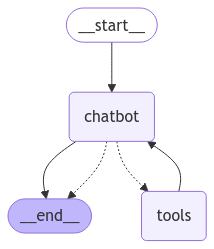

In [16]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))


### Filtering with Tags

If your LLM's output comes from multiple places, you may only want to output messages from a specific node.

In this case, you can add tags to select only the nodes you want to output.

Here's how to add tags to your LLM. Tags can be added as a list.

In [17]:
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


This allows you to filter events more precisely, keeping only events that occurred in that model.

The example below outputs only if the `WANT_TO_STREAM` tag is present.

In [18]:
async for event in graph.astream_events(inputs, version="v2"):
    kind = event["event"]
    tags = event.get("tags", [])
    
    # Filter chat model stream events and end node tags
    if kind == "on_chat_model_stream" and "WANT_TO_STREAM" in tags:
        data = event["data"]
        
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

Here are some of the latest news articles related to AI:

1. **US tech giants announce AI plan worth up to $500bn** - BBC.com
2. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
3. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
4. **Trump announces $500 billion investment for A.I. infrastructure project** - KTVU FOX 2 San Francisco
5. **Trump Announces $100 Billion A.I. Initiative** - The New York Times

If you would like more details on any specific article, let me know!

### Tool Call Streaming
- `AIMessageChunk`: Output messages in real-time, tokenized units.
- `tool_call_chunks`: Tool call chunks. If tool_call_chunks exists, output tool call chunks cumulatively. (Tool tokens are determined by looking at this property)

In [19]:
from langchain_core.messages import AIMessageChunk, HumanMessage

inputs = {"messages": [("human", "Search for the latest AI news")]}

# set the flag whether to process the first message
first = True

for msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # Handle content output when it's not a user message
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        # Print accumulated tool call information when a tool call chunk exists
        if msg.tool_call_chunks:
            print(gathered.tool_calls[0]["args"])


{}
{}
{}
{'query': ''}
{'query': 'AI'}
{'query': 'AI'}
- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San FranciscoHere are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 billion AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
5. **Trump announces $500 billion investment for A.I. infrastructure project** - KTVU FOX 2 San Francisco

Let me know if you need more information on any 

## Working with Subgraphs
In this part, we'll learn how to structure your graph using Subgraphs.

Subgraphs is a feature that allows you to define parts of a graph as subgraphs.

### Example Flow

1. Subgraphs reuse the existing ability to search for the latest news.
2. The Parent Graph adds the ability to generate social media posts based on the latest news retrieved.

In [20]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. State Definition ##########
class State(TypedDict):
    # Add message list annotation
    messages: Annotated[list, add_messages]


########## 2. Tool Definition and Binding ##########
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join([f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)])


# Create tool list
tools = [search_keyword]

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini")

# Combine tools with LLM (add tags)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])

########## 3. Add Nodes ##########
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def create_sns_post(state: State):
    sns_prompt = """
Please convert the previous conversation into a social media post format.
Follow these guidelines:
- Include hashtags
- Use emojis
- Use concise and engaging writing style
- Keep it within 200 characters
"""
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4o-mini").with_config(tags=["WANT_TO_STREAM2"])
    return {"messages": [sns_llm.invoke(messages)]}


def create_subgraph():
     # Create state graph for subgraph
    subgraph = StateGraph(State)

    subgraph.add_node("chatbot", chatbot)

    # Create and add tool node
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)

    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )

    # tools > chatbot
    subgraph.add_edge("tools", "chatbot")

    # START > chatbot
    subgraph.add_edge(START, "chatbot")

    # chatbot > END 
    subgraph.add_edge("chatbot", END)

    return subgraph.compile()

# Create main graph
graph_builder = StateGraph(State)

# Add subgraph
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)

# Add SNS post creation node
graph_builder.add_node("sns_post", create_sns_post)

# START > news_subgraph
graph_builder.add_edge(START, "news_subgraph")

# news_subgraph > sns_post
graph_builder.add_edge("news_subgraph", "sns_post")

# sns_post > END
graph_builder.add_edge("sns_post", END)

# Compile graph
graph = graph_builder.compile()

We can visualize the subgraph flow using xray option.

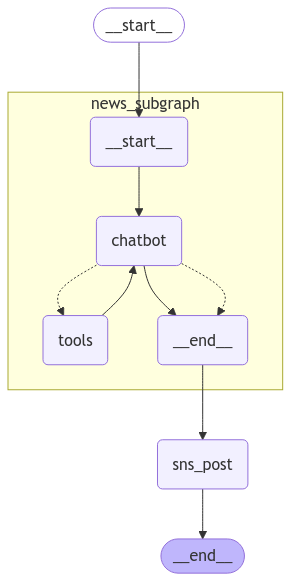

In [21]:
from IPython.display import display, Image

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Now let's see how our graph processes and outputs the results when searching for AI news.

In [22]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

# Process and output node updates sequentially
for chunk in graph.stream(inputs, stream_mode="updates"):
      # node_name: current processing node name
      # node_chunk: chunk data for that node
    for node_name, node_chunk in chunk.items():
        print(f"\n========= Update from node {node_name} =========\n")
        # Output updated data for the node
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)



========= Update from node news_subgraph =========

================================== Ai Message ==================================

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
5. **Trump announces $500 billion investment for A.I. infrastructure project** - KTVU FOX 2 San Francisco

If you would like more details about any of these articles, let me know!

========= Update from node sns_post =========

================================== Ai Message ==================================

🚀 Big news in AI! Trump just announced a massive $500 billion investment for AI infrastructure! 💰 Plus, Google drops another $1B on Anthropic! Exciting times ahead! 🤖✨ #AI #Inno

### When including Subgraphs output

You can also include the output of Subgraphs via `subgraphs=True`.

The output will be in the form `(namespace, chunk)`.

In [23]:
inputs = {"messages": [("human", "Search for the latest AI news")]}

# Formatting function to convert namespace string to a readable format
def format_namespace(namespace):
    return (
        namespace[-1].split(":")[0]
        if len(namespace) > 0
        else "parent graph"
    )

# Using subgraphs=True to include subgraph outputs in (namespace, chunk) format
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    # node_name: current processing node name
    # node_chunk: chunk data for that node
    for node_name, node_chunk in chunk.items():
        print(f"\n========= Update from node [{node_name}] in [{format_namespace(namespace)}] =========\n")

        # Output node's chunk data
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)



========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_oydQcSskSQeUUPFeh9iCATpT)
 Call ID: call_oydQcSskSQeUUPFeh9iCATpT
  Args:
    query: AI

========= Update from node [tools] in [news_subgraph] =========

================================= Tool Message =================================
Name: search_keyword

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco

========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================



### Streaming LLM Output Token by Token Inside Subgraphs
`kind` indicates the type of event.

See the [LangChain `astream_events()` reference](https://python.langchain.com/api_reference/langchain/agents/langchain.agents.agent.AgentExecutor.html#langchain.agents.agent.AgentExecutor.astream_events) for all event types.

In [24]:
# Function to parse namespace information
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"

kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # Extract event type and tag information
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # Filter chat model stream events and final node tags
    elif kind == "on_chat_model_stream":
        data = event["data"]

        # Stream output token by token
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)            

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)



========= on_chat_model_start =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco

========= on_chat_model_start =========

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
5. **Trump announces $500 billion investment for 

### For streaming output of only specific tags

`ONLY_STREAM_TAGS` allows you to set only the tags you want to stream output.

Here we see that "WANT_TO_STREAM2" is excluded from the output and only "WANT_TO_STREAM" is output.

In [25]:
# Function to parse namespace information
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"

# Set tags for streaming output
ONLY_STREAM_TAGS = ["WANT_TO_STREAM"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # Extract event type and tag information
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # Filter chat model stream events and final node tags
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                data = event["data"]

                # Output message
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)            

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========




========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- Trump announces up to $500 billion in private sector AI infrastructure investment - CBS News
- Trump Announces $100 Billion A.I. Initiative - The New York Times
- Oracle shares rise 9% after Trump unveils $500 bln AI plan - Reuters
- Google Invests Another $1 Billion in AI Developer Anthropic - Bloomberg
- Trump announces $500 billion investment for A.I. infrastructure project - KTVU FOX 2 San Francisco

========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========

Here are the latest news articles related to AI:

1. **Trump announces up to $500 billion in private sector AI infrastructure investment** - CBS News
2. **Trump Announces $100 Billion A.I. Initiative** - The New York Times
3. **Oracle shares rise 9% after Trump unveils $500 bln AI plan** - Reuters
4. **Google Invests Another $1 Billion in AI Developer Anthropic** - Bloomberg
5. **Trump announces $500 billion investment for A.I. infrastructure pro